In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

# Define Borders and Border Streets

## Open Tasks

- [x] Add read file-step between sub modules
- [x] Add 2m-buffer streets für border crossing analyses
- [x] Export neighbors, border-shares and border crossing in one file 
- [x] Check paths

---

## Read Countries File
extracted from world with **international-clip.ipynb**

*(europe: UK vs GB)*

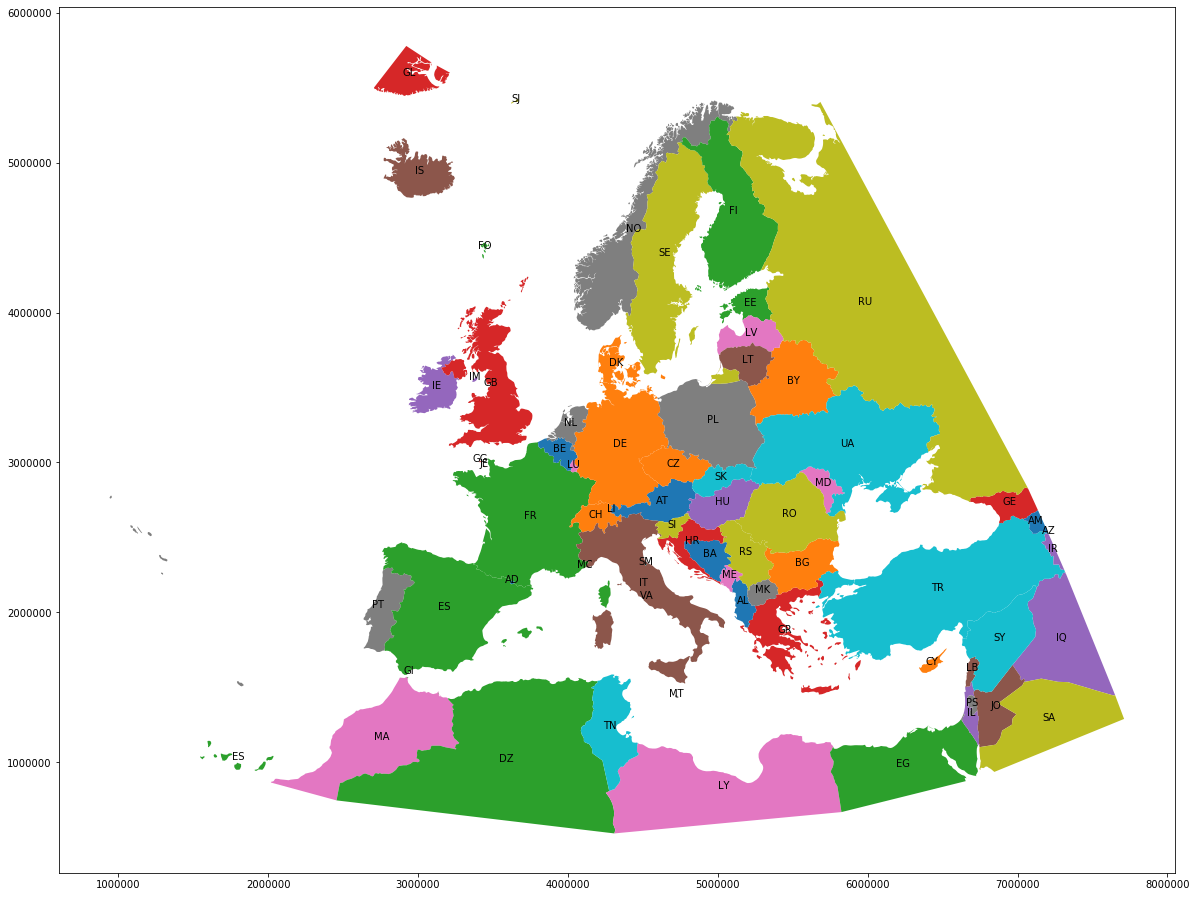

In [2]:
europe_clipped=gpd.read_file(r"input/europe_clipped.gpkg")
europe_clipped=europe_clipped.to_crs('epsg:3035')

ax=europe_clipped.plot(figsize=(20,30), column='ISO')
europe_clipped.apply(lambda x: ax.annotate(s=x.ISO, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

In [3]:
europe_clipped.head()

,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Length,SHAPE_Area,geometry
0,Gibraltar,GI,United Kingdom,GB,0.144833,0.000786,"POLYGON ((2938663.918 1593834.626, 2938137.010..."
1,Morocco,MA,Morocco,MA,56.103257,62.463166,"POLYGON ((3001712.816 1468008.791, 3007265.159..."
2,Portugal,PT,Portugal,PT,27.228028,9.641567,"MULTIPOLYGON (((2763799.229 2184359.347, 27634..."
3,Greenland,GL,Denmark,DK,942.221329,660.927165,"MULTIPOLYGON (((3212900.983 5600002.522, 32113..."
4,Guernsey,GG,United Kingdom,GB,0.416945,0.009025,"POLYGON ((3412469.922 3001371.478, 3412014.691..."


## Set Borders

In [4]:
#set borderbuffer
borderbuffer= 5000# in meter

europe_clipped_buff=europe_clipped.copy()
europe_clipped_buff['geometry']=europe_clipped.buffer(borderbuffer/2)


df= europe_clipped_buff
field='ISO'

gdf_borderbuffer= gpd.GeoDataFrame()

for country in df[field].unique():
    
    country_=df[df[field]==country]
    country_=country_['geometry'].buffer(1)

    for index, row in df.iterrows():

        if row[field]!=country:
            #print (row.CNTR_CODE)
            intersec=country_.intersection(row.geometry.buffer(1))
            
            #print (intersec)
            #print ('-----')
            if not intersec.values.is_empty[0]:
                #print (intersec.values)
                gdf_borderbuffer=gdf_borderbuffer.append({'country1':country,'country2':row[field] ,'geometry':intersec.values[0]}, ignore_index=True)
                               
#merge both border sides to one border buffer
self_merge= pd.merge (gdf_borderbuffer,gdf_borderbuffer, left_on=['country1','country2'], right_on=['country2','country1'])

self_merge['m']=''
for index, row in self_merge.iterrows():
    cont= set([row['country1_x'], row['country2_x']])
    self_merge.at[index, 'm' ]= str(cont)
    
self_merge= self_merge.drop_duplicates(['m']).copy()


gdf_borderbuffer_merged= gpd.GeoDataFrame()
for index, row in self_merge.iterrows():
    merged_border_geom=row.geometry_x.union(row.geometry_y)
    gdf_borderbuffer_merged=gdf_borderbuffer_merged.append({'country1':row['country1_x'],'country2':row['country2_x'],'geometry':merged_border_geom}, ignore_index=True)
    
    
gdf_borderbuffer_merged['border']=gdf_borderbuffer_merged['country1'] + gdf_borderbuffer_merged['country2']
gdf_borderbuffer_merged.crs = 'epsg:3035'

In [5]:
gdf_borderbuffer_merged.to_file('input/borderbuffer.gpkg',driver="GPKG")

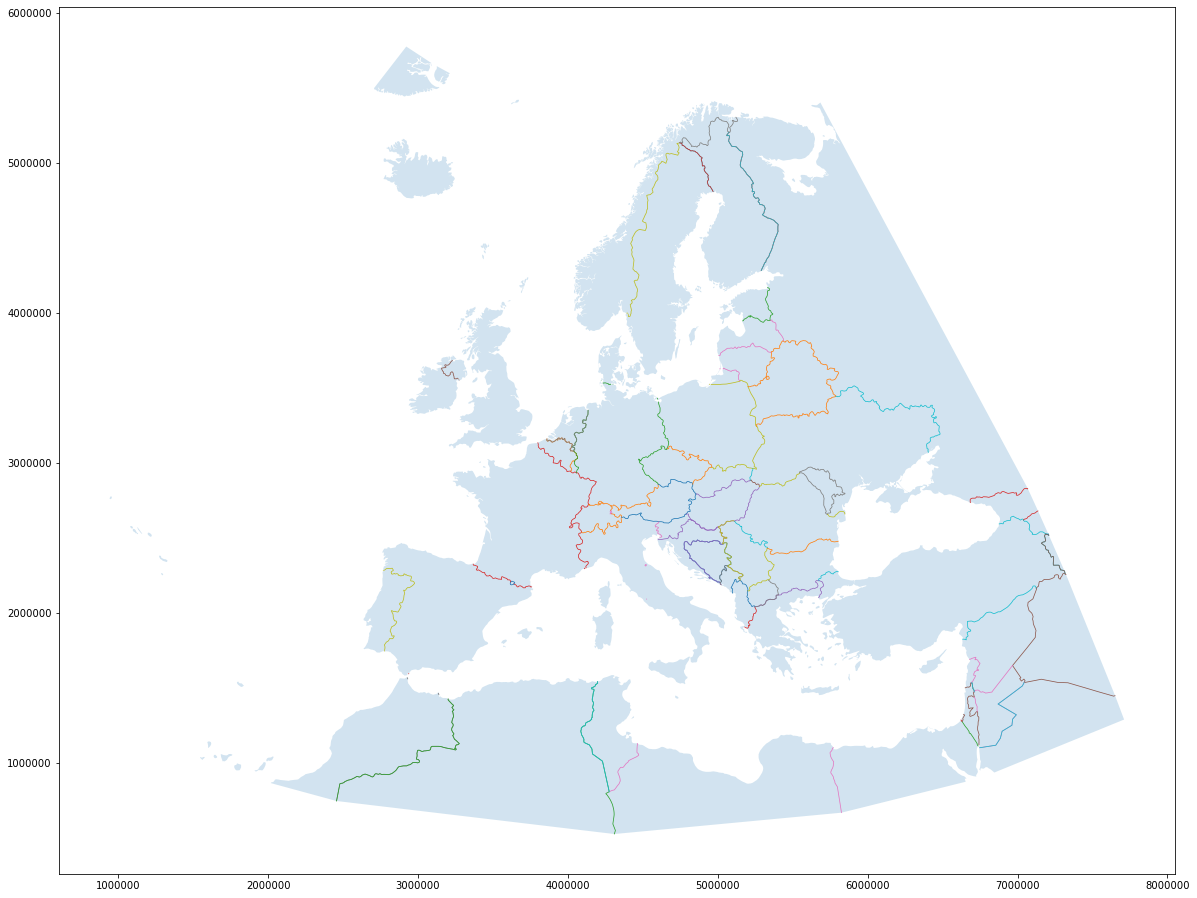

In [6]:
ax=europe_clipped.plot(figsize=(20,30), alpha=0.2)
gdf_borderbuffer_merged.plot(ax=ax, column='border')

---

## Define Shared Borders

In [7]:
gdf_border_merged = gpd.read_file('input/borderbuffer.gpkg')

In [8]:
border_shares= pd.DataFrame()

all_country_codes=set(list(gdf_borderbuffer_merged['country1'])+list(gdf_borderbuffer_merged['country2']))
for country in all_country_codes:
    
    ctr_poly=europe_clipped[europe_clipped.ISO==country]
    ctr_border_buffer=gdf_borderbuffer_merged[(gdf_borderbuffer_merged['country1']==country) | (gdf_borderbuffer_merged['country2']==country)]

    
    ctr_border_line = gpd.GeoDataFrame([1], geometry=[ctr_poly['geometry'].values[0].boundary])

    ctr_border_clipped = gpd.clip(ctr_border_line, ctr_border_buffer)
    
    border_length       = ctr_border_line.length.values[0]/1000
    border_length_shared= ctr_border_clipped.length.values[0]/1000
    ctr_border_share= (border_length_shared/border_length)
    
    border_shares=border_shares.append({'country':country,'border_share':ctr_border_share,'border_length':border_length,'border_length_shared':border_length_shared}, ignore_index=True)

In [9]:
border_shares.head()

,border_length,border_length_shared,border_share,country
0,1141.984310,955.604858,0.836793,IL
1,5907.660081,2159.567851,0.365554,FR
2,1498.966496,1000.667736,0.667572,LV
3,6879.395733,4068.929115,0.591466,UA
4,2.975206,2.975206,1.000000,VA


In [53]:
border_shares.to_csv('output/border-shares.csv', index=False)

---

## Border Streets

In [11]:
gdf_borderbuffer_merged = gpd.read_file('input/borderbuffer.gpkg')

In [12]:
net=gpd.read_file(r"input\lines-border-nutsid.gpkg")
net.head()

,osm_id,highway,oneway,junction,grenze,NUTS_ID,geom_len,geometry
0,73,primary,yes,None,0,UKI71,8,"LINESTRING (3618620.553 3215959.506, 3618623.9..."
1,74,primary,None,None,0,UKI71,18,"LINESTRING (3617413.294 3214941.334, 3617425.6..."
2,75,primary,None,None,0,UKI71,62,"LINESTRING (3618773.573 3216504.927, 3618765.8..."
3,79,primary,None,None,0,UKI71,674,"LINESTRING (3617008.948 3214480.394, 3617021.0..."
4,188,primary,yes,None,0,UKJ32,151,"LINESTRING (3522979.626 3150106.869, 3522984.4..."


In [16]:
net.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
gdf_borderbuffer_merged.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [22]:
#takes ~5min
borderbuffer_streets= gpd.sjoin(net,gdf_borderbuffer_merged)

In [23]:
borderbuffer_streets.head()

,osm_id,highway,oneway,junction,grenze,NUTS_ID,geom_len,geometry,index_right,country1,country2,border
1038,1881629,primary,None,None,0,SE312,2130,"LINESTRING (4436279.758 4309551.636, 4436323.8...",109,NO,SE,NOSE
22306,4363027,trunk,None,None,0,NO031,2814,"LINESTRING (4396610.597 4002952.554, 4396688.7...",109,NO,SE,NOSE
40860,4777346,motorway_link,yes,None,0,NO031,275,"LINESTRING (4393257.919 4001799.433, 4393270.7...",109,NO,SE,NOSE
40861,4777347,primary,None,roundabout,0,NO031,87,"LINESTRING (4393487.374 4001841.604, 4393483.7...",109,NO,SE,NOSE
41004,4780161,primary,None,None,0,NO031,2366,"LINESTRING (4394566.574 4003057.455, 4394552.7...",109,NO,SE,NOSE


In [25]:
borderbuffer_streets.to_file('input/borderbuffer_streets_5km.gpkg', driver = 'GPKG')

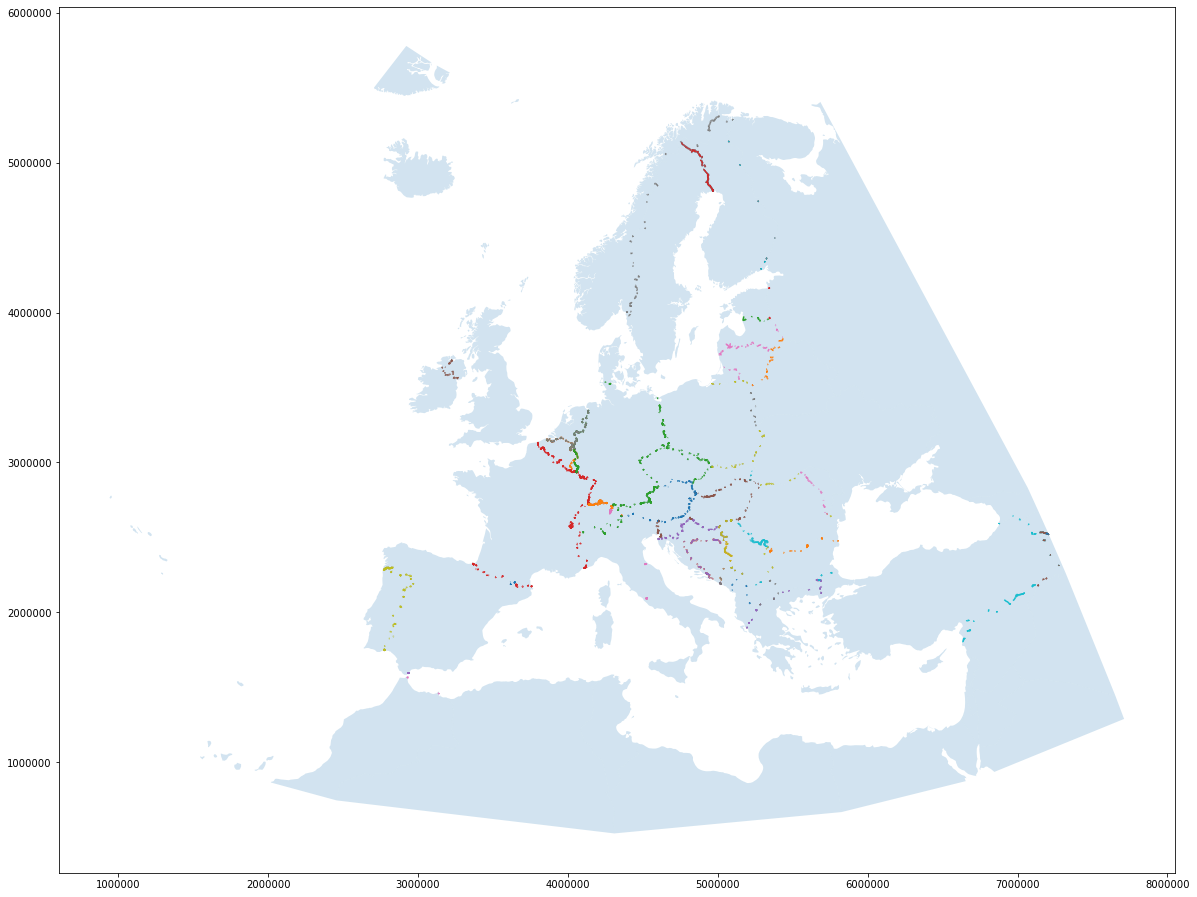

In [27]:
europe_clipped=gpd.read_file(r"input/europe_clipped.gpkg")
europe_clipped=europe_clipped.to_crs('epsg:3035')
ax=europe_clipped.plot(figsize=(20,30), alpha=0.2)

borderbuffer_streets.plot(ax=ax,column='border')

In [28]:
plt.close('all')

---

## Count Neighbors

In [29]:
borderbuffer_streets = gpd.read_file('input/borderbuffer_streets_5km.gpkg')

In [33]:
countries = list(borderbuffer_streets['country1'].unique())
countries.extend(list(borderbuffer_streets['country2'].unique()))
countries = set(countries)

In [50]:
dict_ = {}
for c in countries:
    tab = borderbuffer_streets[(borderbuffer_streets['country1'] == c) | (borderbuffer_streets['country2'] == c)].copy()
    adj = len(tab['border'].unique())
    dict_.update({c: {'country':c, 'neighbors': adj}})
neighbors = pd.DataFrame.from_dict(dict_, orient = 'index')

neighbors.to_csv('output/neighbors.csv')
neighbors.head()

,country,neighbors
FR,FR,8
LV,LV,4
VA,VA,1
UA,UA,5
FI,FI,5


---

## Get number of border streets per country

- 2m buffer used to not accidentally include streets that are close to the border

In [38]:
europe_clipped=gpd.read_file(r"input/europe_clipped.gpkg")
europe_clipped=europe_clipped.to_crs('epsg:3035')

net=gpd.read_file(r"input\lines-border-nutsid.gpkg")

In [39]:
#set borderbuffer
borderbuffer= 2# in meter

df= europe_clipped
field='ISO'#'CNTR_CODE'

df_buff=df.copy()
df_buff['geometry']=df.buffer(borderbuffer/2)

border_2m= gpd.GeoDataFrame()

for country in df[field].unique():
    
    country_=df[df[field]==country]
    country_=country_['geometry'].buffer(1)

    for index, row in df.iterrows():

        if row[field]!=country:
            #print (row.CNTR_CODE)
            intersec=country_.intersection(row.geometry.buffer(1))
            
            #print (intersec)
            #print ('-----')
            #if not intersec[0].is_empty:
            if not intersec.values.is_empty[0]:
                #print (intersec.values)
                border_2m=border_2m.append({'country1':country,'country2':row[field] ,'geometry':intersec.values[0]}, ignore_index=True)
                               
#merge both border sides to one border buffer
self_merge= pd.merge(border_2m,border_2m, left_on=['country1','country2'], right_on=['country2','country1'])

self_merge['m']=''
for index, row in self_merge.iterrows():
    cont= set([row['country1_x'], row['country2_x']])
    self_merge.at[index, 'm' ]= str(cont)
    
self_merge= self_merge.drop_duplicates(['m']).copy()


border_2m= gpd.GeoDataFrame()
for index, row in self_merge.iterrows():
    merged_border_geom=row.geometry_x.union(row.geometry_y)
    border_2m=border_2m.append({'country1':row['country1_x'],'country2':row['country2_x'],'geometry':merged_border_geom}, ignore_index=True)
    
    
border_2m['border']=border_2m['country1'] + border_2m['country2']

border_2m.crs='EPSG:3035'

#takes ~5min
borderbuffer_streets2m = gpd.sjoin(net,border_2m)

In [40]:
country1_grp=borderbuffer_streets2m.groupby(['country1','highway'])['grenze'].count().reset_index()
country2_grp=borderbuffer_streets2m.groupby(['country2','highway'])['grenze'].count().reset_index()

In [41]:
country1_grp=country1_grp.rename(columns={'country1':'country'})
country2_grp=country2_grp.rename(columns={'country2':'country'})

In [43]:
country_grp=country1_grp.append(country2_grp)

country_grp=country_grp.groupby(['country','highway'])['grenze'].sum().reset_index()

In [44]:
piv_table = pd.pivot_table(country_grp, values='grenze', index=['country'],columns=['highway']).reset_index()
piv_table.head()

highway,country,motorway,motorway_link,primary,primary_link,trunk,trunk_link
0,AD,NaN,NaN,3.0,NaN,1.0,NaN
1,AL,NaN,NaN,15.0,NaN,2.0,NaN
2,AM,NaN,NaN,NaN,NaN,2.0,NaN
3,AT,32.0,21.0,83.0,NaN,3.0,2.0
4,AZ,NaN,NaN,NaN,NaN,2.0,NaN


In [45]:
piv_table=piv_table.fillna(0)

In [49]:
piv_table['allhighways']=piv_table['motorway']+piv_table['motorway_link']+piv_table['primary']+piv_table['primary_link']+piv_table['trunk']+piv_table['trunk_link']
piv_table.head()

highway,country,motorway,motorway_link,primary,primary_link,trunk,trunk_link,allhighways
0,AD,0.0,0.0,3.0,0.0,1.0,0.0,4.0
1,AL,0.0,0.0,15.0,0.0,2.0,0.0,17.0
2,AM,0.0,0.0,0.0,0.0,2.0,0.0,2.0
3,AT,32.0,21.0,83.0,0.0,3.0,2.0,141.0
4,AZ,0.0,0.0,0.0,0.0,2.0,0.0,2.0


In [48]:
piv_table.to_csv('output/border-crossings.csv')

---

## Export CSV with all Data

In [ ]:
border_shares = pd.read_csv('output/border-shares.csv')
neighbors     = pd.read_csv('output/neighbors.csv')
piv_table     = pd.read_csv('output/border-crossings.csv')

In [52]:
export_csv = pd.merge(border_shares,neighbors, on = 'country')
export_csv = pd.merge(export_csv,piv_table, on = 'country')

export_csv['border_crossings_per_100']=100/(export_csv['border_length_shared']/export_csv['allhighways'])

export_csv.to_csv('output/international-data-countries.csv')
export_csv.head()

,border_length,border_length_shared,border_share,country,neighbors,motorway,motorway_link,primary,primary_link,trunk,trunk_link,allhighways,border_crossings_per_100
0,5907.660081,2159.567851,0.365554,FR,8,36.0,5.0,90.0,0.0,26.0,4.0,161.0,7.455195
1,1498.966496,1000.667736,0.667572,LV,4,0.0,0.0,11.0,0.0,11.0,0.0,22.0,2.198532
2,6879.395733,4068.929115,0.591466,UA,5,0.0,0.0,13.0,0.0,4.0,0.0,17.0,0.417800
3,4822.182385,2359.218803,0.489243,FI,5,0.0,0.0,26.0,0.0,58.0,0.0,84.0,3.560501
4,1204.574824,1203.461250,0.999076,BA,6,16.0,2.0,88.0,0.0,0.0,0.0,106.0,8.807928


---